In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper. I import my modules and dependencies
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# I can use automap_base to reflect the database
Base = automap_base()

# reflect the tables

Base.prepare(engine, reflect=True)

In [8]:
# This line checks the classes or the two data tables hawaii_meausurements and hawaii_stations
Base.classes.keys()

['measurement', 'station']

In [9]:
# I save these two classes as measurement and stations
measurement = Base.classes.measurement
stations = Base.classes.station

# I also used the inspector to check the datatypes and if the columns were reflected properly from the csv
inspector = inspect(engine)

columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# This line creates the session to run the engine for the analyses in the code. 
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# The first step is to find what the most recent date in the db is. We can find it with the max() on the date type. I prefer this over the last row method because we don't know if this set is ordered or not. Also, I used session queries and filters
# later on in the code, but I also wanted to practice with executing SQL searches and using pd.read_sql_query so I did it both ways in this code. 

last_date = engine.execute('SELECT MAX (date) as "Last Date" FROM measurement').fetchall()
last_date

[('2017-08-23',)]

In [12]:
# I used the datetime module and a time delta of 365 years to calculate the date 1 year ago from the last data point in the database

query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Query Date: ", query_date)

Query Date:  2016-08-23


In [13]:
# For practice, I directly read the sql into a dataframe with read_sql_query. I used standard sql query language in a string text and just had to reference the engine defined above. 
result = pd.read_sql_query('SELECT date, prcp FROM measurement', engine)

result

# Since I converted directly to a PD data frame I converted my date column into datetime and then could perform a loc function to get my desired date range. 

result['date']= pd.to_datetime(result['date'])
last_year = result.loc[result['date'] > '2016-08-22'].reset_index(drop=True)

#I reset the index and then sorted it to get a final DF sorted_year printed below.

last_year.set_index('date', inplace=True)
sorted_year =last_year.sort_values(by='date', ascending=True).dropna().reset_index()
sorted_year

,date,prcp
0,2016-08-23,0.00
1,2016-08-23,1.79
2,2016-08-23,0.05
3,2016-08-23,0.15
4,2016-08-23,0.70
...,...,...
2016,2017-08-22,0.00
2017,2017-08-23,0.00
2018,2017-08-23,0.00
2019,2017-08-23,0.08


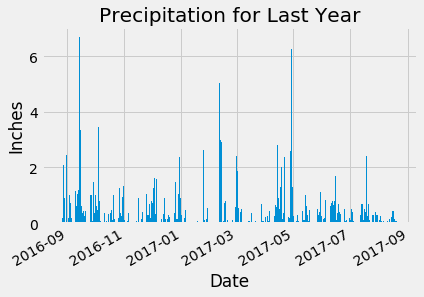

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data. I used autofmt_xdate to make the date tick marks look better and properly titled it from the dataframe to get the chart. 
fig, ax = plt.subplots()

x_values = sorted_year['date']
y_values = sorted_year['prcp']
plt.bar(x_values, y_values)
fig.autofmt_xdate()
plt.title('Precipitation for Last Year')
plt.ylabel('Inches')
plt.xlabel('Date')
plt.show();


In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data. Describe is an efficient way to get the summary statistics necessary to get a broad overview of the data. 
last_year.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [93]:
# I used a count distinct function to count how many different stations were in the stations

station_query =  engine.execute('SELECT COUNT (DISTINCT station) as total FROM station').fetchall()
station_query


[(9,)]

In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

# Once I again I tried this with executing direct sql query langage and executing it in the enging to get a sorted list of stations and their frequency of observations. 

activity_query = 'SELECT station, COUNT (prcp) FROM measurement GROUP BY station ORDER BY COUNT (prcp) desc'

active_stations = engine.execute(activity_query).fetchall()
active_stations


[('USC00519281', 2772),
 ('USC00513117', 2696),
 ('USC00519397', 2685),
 ('USC00519523', 2572),
 ('USC00516128', 2484),
 ('USC00514830', 1937),
 ('USC00511918', 1932),
 ('USC00517948', 683),
 ('USC00518838', 342)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

# This is very similar to above, but just need to include the aggregation methods and also filter with WHERE and the station id.

active_station_query = 'SELECT station, MAX (tobs), MIN (tobs), AVG (tobs) FROM measurement WHERE station = "USC00519281"'
most_active = engine.execute(active_station_query).fetchall()
most_active

[('USC00519281', 85.0, 54.0, 71.66378066378067)]

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_active = pd.read_sql_query('SELECT date, tobs FROM measurement WHERE station = "USC00519281"', engine)

# Perform a query to retrieve the data and precipitation scores

most_active['date']= pd.to_datetime(most_active['date'])
last_year_most_active = most_active.loc[most_active['date'] > "2016-08-23", :].reset_index(drop=True)
last_year_most_active.sort_values(by='date', ascending=True)

,date,tobs
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0
...,...,...
346,2017-08-14,77.0
347,2017-08-15,77.0
348,2017-08-16,76.0
349,2017-08-17,76.0


In [20]:
# Comment about trouble with datetime. I got hung up for a bit that the module datetime has the function datetime. So I struggled a bit with getting datetime format correctly until I figured that out. That is confusing nomenclature to have the module
# and a function in a module named the same thing. That's why I wrote out the months long form. Also, even though these don't cover the full-year data, I chose by calendar dates and to label it that way. I could have listed by 30 day increments using 
# timedelta as well, but felt this looked a little more visually appealing. Also, I realized looking back in the readme that this wasn't what it was asking when sorting measurments frequency by temperature bins, but I liked the graph so I kept it in!!

sept16 = dt.datetime(2016, 9, 1)
octo = dt.datetime(2016, 10, 1)
nov = dt.datetime(2016, 11, 1)
dec = dt.datetime(2016, 12, 1)
jan = dt.datetime(2017, 1, 1)
feb = dt.datetime(2017, 2, 1)
mar = dt.datetime(2017, 3, 1)
apr = dt.datetime(2017, 4, 1)
may = dt.datetime(2017, 5, 1)
jun = dt.datetime(2017, 6, 1)
jul = dt.datetime(2017, 7, 1)
aug = dt.datetime(2017, 8, 1)
sept17 = dt.datetime(2017, 9, 1)

bins =[sept16, octo, nov, dec, jan, feb, mar, apr, may, jun, jul, aug, sept17]

In [21]:
group_names = ["Sept", "Oct", "Nov", "Dec", "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug"]

last_year_most_active["Monthly_Temp"] = pd.cut(last_year_most_active['date'], bins, labels=group_names, include_lowest=True)
monthly_temps = last_year_most_active.groupby(last_year_most_active['Monthly_Temp']).mean().dropna().reset_index()
monthly_temps

,Monthly_Temp,tobs
0,Sept,77.741935
1,Oct,76.419355
2,Nov,73.566667
3,Dec,70.354839
4,Jan,68.193548
5,Feb,68.321429
6,Mar,70.709677
7,Apr,70.666667
8,May,73.580645
9,Jun,74.733333


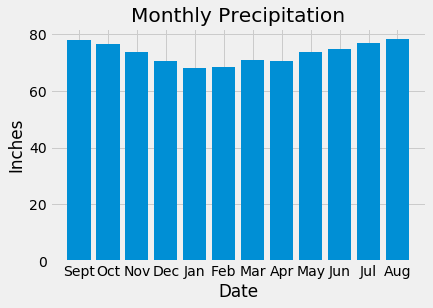

In [22]:
fig, ax = plt.subplots()

x_values = monthly_temps['Monthly_Temp']
y_values = monthly_temps['tobs']
plt.bar(x_values, y_values)
plt.title('Monthly Precipitation')
plt.ylabel('Inches')
plt.xlabel('Date')
plt.show();

In [23]:
# Using the describe method again gets the descriptive statistics in order to create bins for the next graph by finding the min and max. 

last_year_most_active.describe()

,tobs
count,351.000000
mean,73.096866
std,4.735491
min,59.000000
25%,70.000000
50%,74.000000
75%,77.000000
max,83.000000


In [24]:
# I binned the data into "roughly" even intervals. Sometimes because the tails have less data I made them 3 degrees instead of two for the rest. 

bins =[59, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 83]
group_names = ['59-62', '62-64', '64-66', '66-68', '68-70', '70-72', '72-74', '74-76', '76-78', '78-80', '80-83']

last_year_most_active["obs_per_temp"] = pd.cut(last_year_most_active['tobs'], bins, labels=group_names, include_lowest=True)
last_year_most_active

obs_per_temprange = last_year_most_active.groupby(last_year_most_active['obs_per_temp']).count().reset_index()
obs_per_temprange

,obs_per_temp,date,tobs,Monthly_Temp
0,59-62,12,12,12
1,62-64,7,7,7
2,64-66,12,12,12
3,66-68,27,27,27
4,68-70,41,41,41
5,70-72,40,40,40
6,72-74,57,57,56
7,74-76,66,66,65
8,76-78,52,52,48
9,78-80,29,29,27


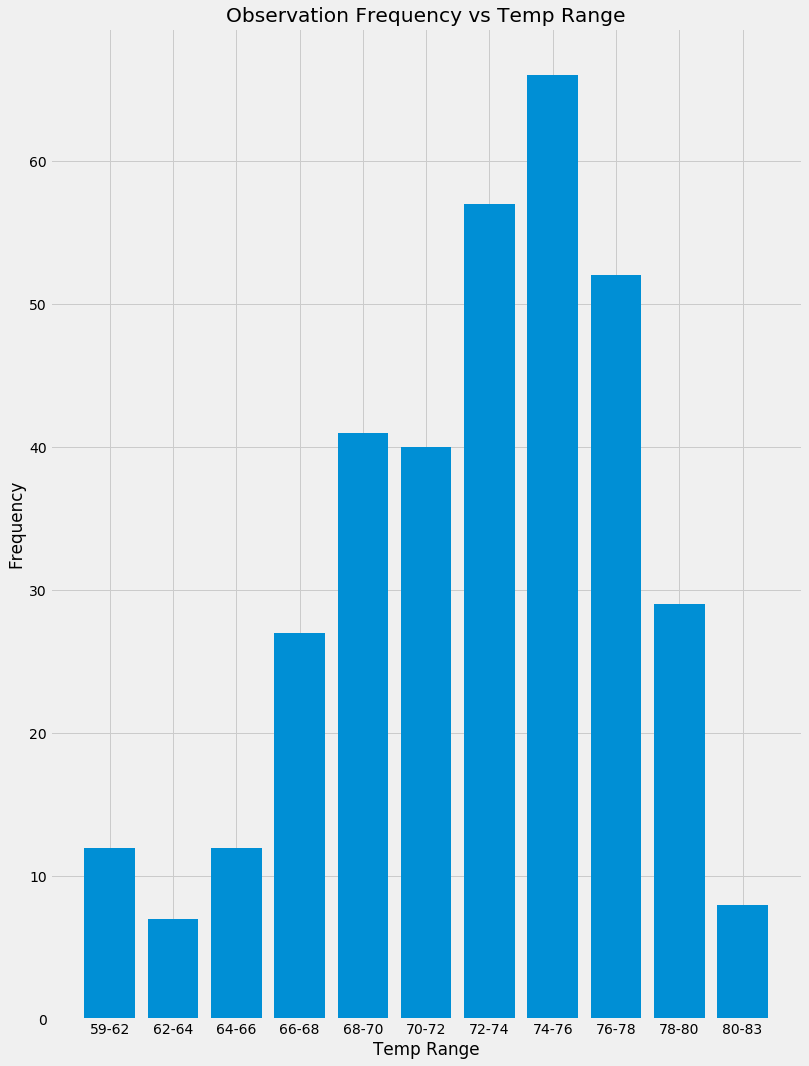

In [25]:
plt.figure(figsize=(12,17));
x_values = obs_per_temprange['obs_per_temp']
y_values = obs_per_temprange['tobs']
plt.bar(x_values, y_values)
plt.title('Observation Frequency vs Temp Range')
plt.ylabel('Frequency')
plt.xlabel('Temp Range');


## Flask Climate APP

In [91]:
# Full disclaimer, I worked off the ipynb starter code. I thought I had finished the hw Tuesday before class, but I re-read and saw that I had completely missed the Flask portion! Whoops!!! After class I wrote up the @app.routes here to show I could 
# do them. And I submitted as much as I was able to do Tuesday night. But I will create another commit where I debug and get the Flask api searches functioning properly. 

from flask import Flask, jsonify

# Flask Setup
app = Flask(__name__)


#################################################
# Flask Routes
#################################################

@app.route("/")
def welcome():
    """List all available api routes."""
    return (
        f"Available Routes:<br/>"
        f"/api/v1.0/precipitation<br/>"
        f"/api/v1.0/stations<br/>"
        f"/api/v1.0/tobs<br/>"
        f"/api/v1.0/<start><br/>"
        f"/api/v1.0/<start>/<end>"
    )



# Convert the query results to a dictionary using `date` as the key and `prcp` as the value.

@app.route("/api/v1.0/precipitation")
def precipitation():
    # Create our session (link) from Python to the DB
    session = Session(engine)

    """Return a list of precipitation measurments"""
    # Query prcp measurements
    sel = [measurement.date, measurement.prcp]
    results = session.query(*sel).all()
    
    session.close()
        
        # Create a dictionary from the row data and append to a list of all_prcp
    all_precipitation = []
    for date, precpitation in results:
        precipitation_dict = {}
        precipitation_dict["date"] = date
        passenger_dict["prcp"] = precipitation
        all_precipitation.append(passenger_dict)

    return jsonify(all_precipitation)


# Return a JSON list of stations from the dataset.

@app.route("/api/v1.0/stations")
def stations():
    
    session = Session(engine)
    
    sel = [stations.station, stations.name]
    results = session.query(*sel).all()
    
    session.close()
    
    station_list =[]
    for numb, name in results:
        station_dict = {}
        station_dict["number"] = numb
        station_dict["name"] = name
        station_list.append(station_dict)
    
    return jsonify(station_list)
    

#  `/api/v1.0/tobs`
  # Query the dates and temperature observations of the most active station for the last year of data.

@app.route("/api/v1.0/tobs")
def tobs():
    
    session = Session(engine)
    
    sel = [measurement.date, measurement.tobs]
    results = session.query(*sel).filter(measurement.station = "USC00519281").all()
    
    session.close()
    
    top_station =[]
    for date, temp in results:
        top_dict = {}
        top_dict["date"] = date
        top_dict["temp"] = temp
        top_station.append(top_dict)
    
    return jsonify(top_station)
        

# Query the dates and temperature observations of the most active station for the last year of data.
  
# Return a JSON list of temperature observations (TOBS) for the previous year.
    
@app.route("/api/v1.0/tobs")
def tobs():
    
    session = Session(engine)
    
    sel = [measurement.date, measurement.tobs]
    results = session.query(*sel).filter(measurement.station = "USC00519281").filter(measurement.date > '08-23-2016').all()
    
    session.close()
    
    top_station =[]
    for date, temp in results:
        top_dict = {}
        top_dict["date"] = date
        top_dict["temp"] = temp
        top_station.append(top_dict)
    
    return jsonify(top_station)

  


#  Values for date range

@app.route("/api/v1.0/<start>/<end>")
def start(start_date, end_date):
    
    session = Session(engine)
    
    sel = [measurement.date, func.max(measurement.tobs), func.min(measurement.tobs), func.avg(measurement.tobs)]
    results = session.query(*sel).filter(measurement.date >= start_date).filter(measurement.date =< end_date).all()
    
    session.close()
    
    yearly_values =[]
    for station, date, max_val, min_val, avg_val, in results:
        yearly_value_dict = {}
        yearly_value_dict["date"] = date
        yearly_value_dict["high_temp"] = max_val
        yearly_value_dict["low_temp"] = min_val
        yearly_value_dict["avg_temp"] = avg_val
        yearly_values.append(yearly_value_dict)
    
    return jsonify(yearly_values)


if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Restarting with windowsapi reloader


SystemExit: 1

## Bonus Challenge Assignment

In [97]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))


[(62.0, 69.57142857142857, 74.0)]


In [28]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# Since the function is defined above I can simply insert the proper trip dates into that function and print them to get the values.
trip_temps = calc_temps('2016-02-28', '2017-03-05')
print(trip_temps)

[(59.0, 74.11674478057094, 84.0)]


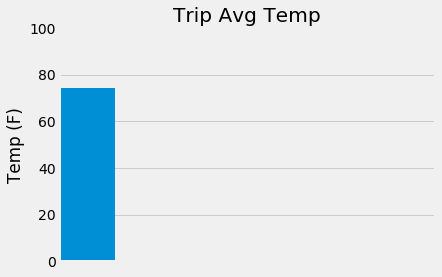

In [100]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

x = 'temp'
y = 74.1
yerr_min = 59
yerr_max = 84

fig, ax = plt.subplots()
plt.bar(x,y, width=0.3)
# plt.errorbar(x, y, yerr=84)
ax.set_xlim(0, 1)
ax.set_ylim(0,100)
ax.axes.xaxis.set_visible(False)
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.xlabel('');


In [30]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

def calc_prcp(start_date, end_date):
    """Station, prcpsum for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        station, prcpsum
    """
    
    sel = [stations.name, func.sum(measurement.prcp), stations.latitude, stations.longitude, stations.elevation ]
    
    return session.query(*sel).group_by(measurement.station).order_by(func.sum(measurement.prcp)).\
        filter(stations.station == measurement.station).filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()


print(calc_prcp('2016-02-28', '2017-03-05'))


[('PEARL CITY, HI US', 6.17, 21.3934, -157.9751, 11.9), ('WAIKIKI 717.2, HI US', 22.129999999999995, 21.2716, -157.8168, 3.0), ('KUALOA RANCH HEADQUARTERS 886.9, HI US', 32.29, 21.5213, -157.8374, 7.0), ('WAIMANALO EXPERIMENTAL FARM, HI US', 40.01, 21.33556, -157.71139, 19.5), ('KANEOHE 838.1, HI US', 62.55000000000002, 21.4234, -157.8015, 14.6), ('WAIHEE 837.5, HI US', 89.39000000000003, 21.45167, -157.84888999999998, 32.9), ('MANOA LYON ARBO 785.2, HI US', 173.84, 21.3331, -157.8025, 152.4)]


In [31]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [83]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# I had more trouble with datetime not automatically converting to a date as can be seen by my printed code. I put it in my notes to trouble shoot this as well. 

normals = []

# Set the start and end date of the trip
# Use the start and end date to create a range of dates

start_date = dt.datetime(2017, 2, 28)
trip_length = 5


trip_days = []
for x in range (0, trip_length):
    trip_days.append(start_date + dt.timedelta(days = x))
print(trip_days)


# Stip off the year and save a list of %m-%d strings

month_day_list = []
for day in trip_days:
    dt.datetime.strptime(day, "%m-%d")

for day in month_day_list:
    print(daily_normals(day))
    normals.append(daily_normals(day))

# Loop through the list of %m-%d strings and calculate the normals for each date


[datetime.datetime(2017, 2, 28, 0, 0), datetime.datetime(2017, 3, 1, 0, 0), datetime.datetime(2017, 3, 2, 0, 0), datetime.datetime(2017, 3, 3, 0, 0), datetime.datetime(2017, 3, 4, 0, 0)]


TypeError: strptime() argument 1 must be str, not datetime.datetime

In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
